# Meridional transects of mean planetary geostrophic potential vorticity, potential density anomaly and max/min monthly mean MLD

See [Kiss et al 2020](https://doi.org/10.5194/gmd-13-401-2020) Fig 15

In [1]:
#This cell must be in all notebooks!
#It allows us to run all the notebooks at once, this cell has a tag "parameters" which allows us to pass in 
# arguments externally using papermill (see mkfigs.sh for details)

### USER EDIT start
esm_file = "/g/data/ol01/access-om3-output/access-om3-025/25km-iaf-test-for-AK-expt-7df5ef4c/datastore.json"
dpi=300
### USER EDIT stop

import os
from matplotlib import rcParams
%matplotlib inline
rcParams["figure.dpi"]= dpi

plotfolder="/g/data/tm70/ds0092/projects/access-om3-paper-1/figs/"
os.makedirs(plotfolder, exist_ok=True)

 # a similar cell under this means it's being run in batch
print("ESM datastore path: ",esm_file)
print("Plot folder path: ",plotfolder)

ESM datastore path:  /g/data/ol01/access-om3-output/access-om3-025/25km-iaf-test-for-AK-expt-7df5ef4c/datastore.json
Plot folder path:  /g/data/tm70/ds0092/projects/access-om3-paper-1/figs/


In [2]:
import os
import intake
import numpy as np
import xarray as xr
from distributed import Client
import matplotlib.pyplot as plt

In [3]:
client = Client(threads_per_worker=1)
print(client.dashboard_link)

/proxy/8787/status


# ACCESS-OM3

### Open the intake-esm datastore

In [4]:
COLUMNS_WITH_ITERABLES = [
        "variable",
        "variable_long_name",
        "variable_standard_name",
        "variable_cell_methods",
        "variable_units"
]

om3_experiment = os.path.basename(os.path.dirname(esm_file))
om3_datastore = intake.open_esm_datastore(
    esm_file,
    columns_with_iterables=COLUMNS_WITH_ITERABLES
)

### Open required variables

**TODO**: Should be using `rhopot0`, but this is not currently saved

In [5]:
diag_vars = om3_datastore.search(variable=["rhopot2", "mlotst"], frequency="1mon").to_dataset_dict(
    progressbar=False,
    xarray_open_kwargs=dict(
        use_cftime=True
    )
)
static_vars = om3_datastore.search(variable=["geolat", "geolon"]).to_dask(
    xarray_open_kwargs=dict(
        use_cftime=True
    )
).compute()

ds_om3 = xr.merge([ds for ds in diag_vars.values()]).assign_coords(static_vars)

/g/data/xp65/public/apps/med_conda/envs/analysis3-25.09/lib/python3.11/site-packages/intake_esm/core.py:321: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  records = grouped.get_group(internal_key).to_dict(orient='records')
/g/data/xp65/public/apps/med_conda/envs/analysis3-25.09/lib/python3.11/site-packages/intake_esm/core.py:321: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  records = grouped.get_group(internal_key).to_dict(orient='records')
/g/data/xp65/public/apps/med_conda/envs/analysis3-25.09/lib/python3.11/site-packages/intake_esm/core.py:321: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. 

### Fix issue with `yh`

**TODO:** The `25km-iaf-test-for-AK-expt-7df5ef4c` run has an ordering issue with the bottom ten (masked) rows - see https://github.com/ACCESS-NRI/access-om3-configs/pull/725#pullrequestreview-3174863908. **Future runs will not need this fix.**

In [6]:
ds_om3 = ds_om3.assign_coords(
    {"yh": ds_om3.yh.sortby("yh")}
)

### Only keep last 10 years of data in the region of interest

In [7]:
ds_om3 = ds_om3.isel(
    time=slice(-120,None)
).sel(
    xh=-119.875,
    yh=slice(-90, -15),
    z_l=slice(None, 1700),
).compute()

period_om3 = (
    ds_om3.time[0].item().strftime("%Y-%m-%d"),
    ds_om3.time[-1].item().strftime("%Y-%m-%d")
)

### Calculate the planetary potential vorticity
Constants below are as used in MOM6 by default

**TODO**: Should we use saved `Coriolis` diagnostic here? It's on q-points so would have to be interpolated.

In [8]:
g = 9.80
rho0  = 1040.0
omega  = 7.2921e-5
coriolis = 2.0 * omega * np.sin(np.deg2rad(ds_om3["geolat"]))

dpotrho2dz_om3 = ds_om3["rhopot2"].differentiate(coord="z_l")

pPV_om3 = -coriolis * g / rho0 * dpotrho2dz_om3

# ACCESS-OM2

### Open the intake-esm datastore

In [9]:
cat = intake.cat.access_nri

om2_experiment = "025deg_jra55_iaf_omip2_cycle6"

om2_datastore = cat[om2_experiment]

### Open required variables

In [10]:
diag_vars = om2_datastore.search(variable=["pot_rho_0", "mld"], frequency="1mon").to_dask(
    xarray_open_kwargs=dict(
        use_cftime=True
    )
)
static_vars = om2_datastore.search(variable=["geolat_t", "geolon_t"]).to_dask(
    xarray_open_kwargs=dict(
        use_cftime=True
    )
).compute()

ds_om2 = diag_vars.assign_coords(static_vars.coords)

/g/data/xp65/public/apps/med_conda/envs/analysis3-25.09/lib/python3.11/site-packages/intake_esm/core.py:321: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  records = grouped.get_group(internal_key).to_dict(orient='records')
/g/data/xp65/public/apps/med_conda/envs/analysis3-25.09/lib/python3.11/site-packages/intake_esm/core.py:321: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  records = grouped.get_group(internal_key).to_dict(orient='records')


### Only keep last 10 years of data in the region of interest

In [11]:
ds_om2 = ds_om2.isel(
    time=slice(-120,None)
).sel(
    xt_ocean=-119.875,
    yt_ocean=slice(-90, -15),
    st_ocean=slice(None, 1700),
).compute()

period_om2 = (
    ds_om2.time[0].item().strftime("%Y-%m-%d"),
    ds_om2.time[-1].item().strftime("%Y-%m-%d")
)

### Calculate the planetary potential vorticity

Constants below are as used in MOM5 by default

In [12]:
g = 9.80
rho0  = 1035.0
omega  = 7.292e-5
coriolis = 2.0 * omega * np.sin(np.deg2rad(ds_om2["geolat_t"]))

dpotrho0dz_om2 = ds_om2["pot_rho_0"].differentiate(coord="st_ocean")

pPV_om2 = -coriolis * g / rho0 * dpotrho0dz_om2

# Plot

### Compute OM3 quantities

In [13]:
pPV_plot_om3 = pPV_om3.mean("time")
potrho2_plot_om3 = ds_om3["rhopot2"].mean("time")
mldmin_om3 = ds_om3["mlotst"].min("time")
mldmax_om3 = ds_om3["mlotst"].max("time")

### Compute OM2 quantities

In [14]:
pPV_plot_om2 = pPV_om2.mean("time")
potrho0_plot_om2 = ds_om2["pot_rho_0"].mean("time")
mldmin_om2 = ds_om2["mld"].min("time")
mldmax_om2 = ds_om2["mld"].max("time")

### Create plot

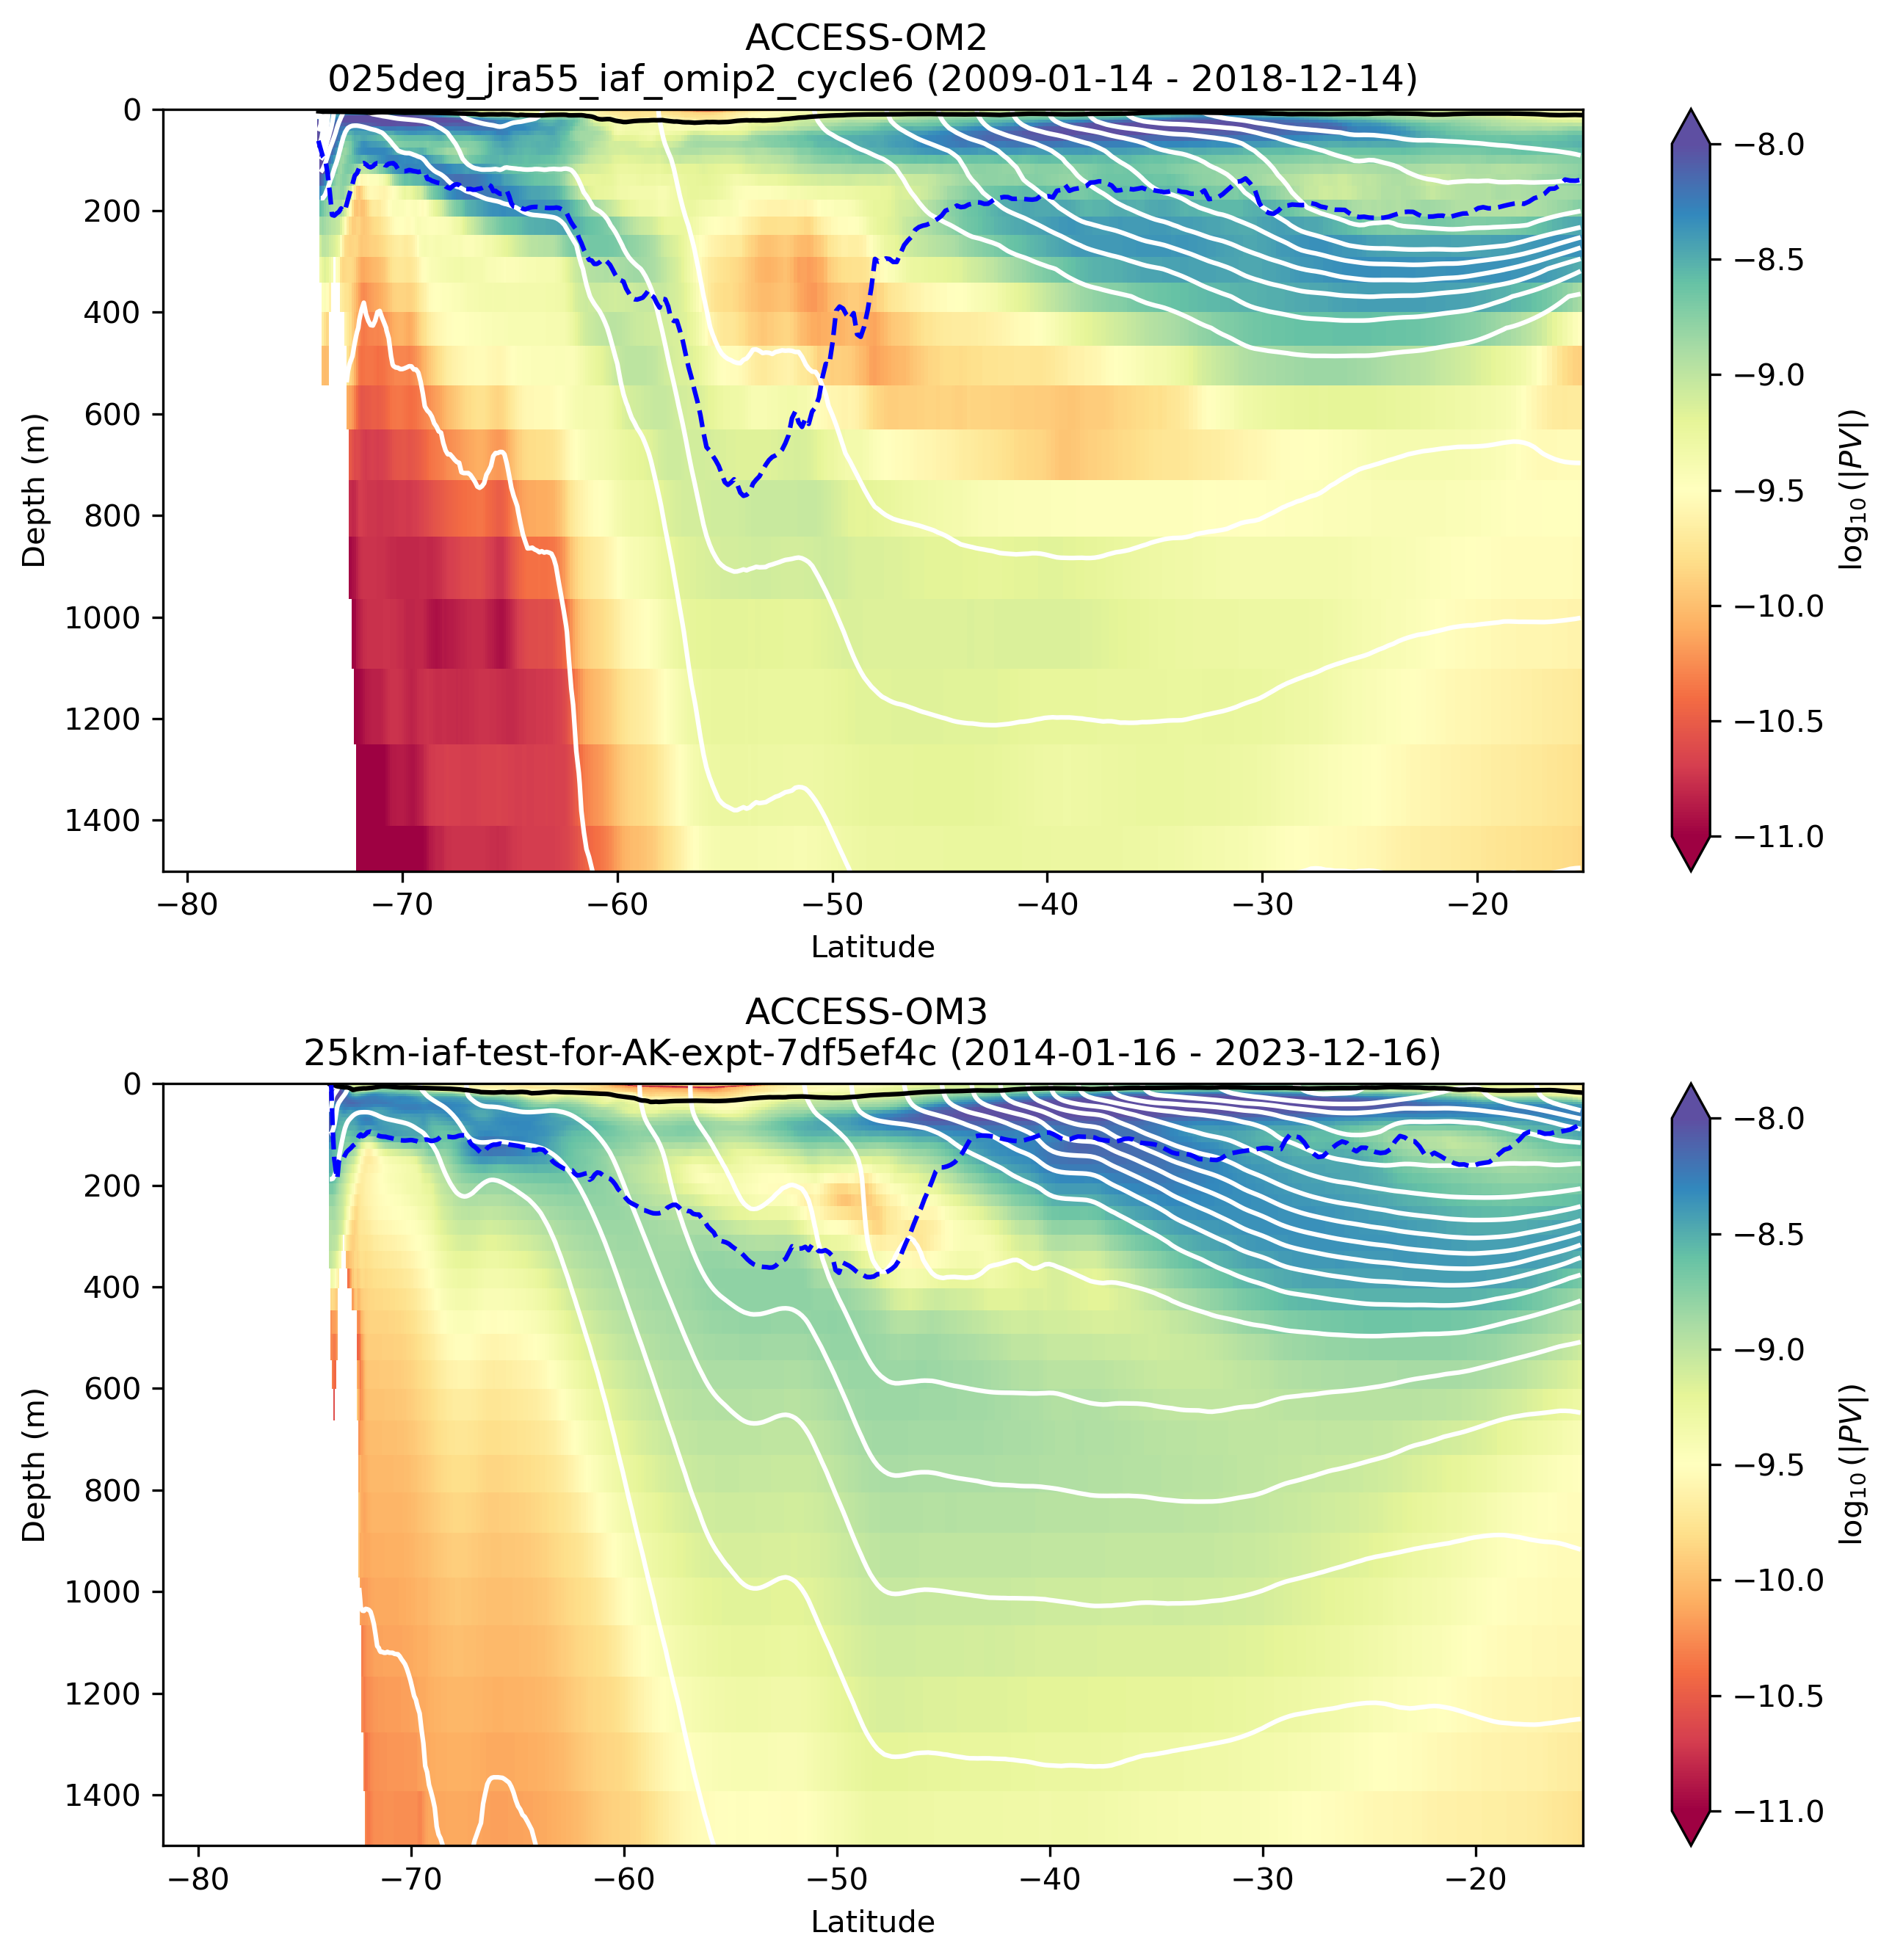

In [15]:
fig, axs = plt.subplots(2, 1, figsize=(9, 9))

# ACCESS-OM2
xr.ufuncs.log10(abs(pPV_plot_om2)).plot(
    ax=axs[0],
    x="yt_ocean",
    cmap="Spectral",
    vmin=-11,
    vmax=-8,
    cbar_kwargs={"label": "$\log_{10}(|PV|)$"},
)
potrho0_plot_om2.plot.contour(
    ax=axs[0],
    levels=np.arange(1024.75, 1030, 0.25),
    colors="w"
)
mldmin_om2.plot(ax=axs[0], color="k")
mldmax_om2.plot(ax=axs[0], color="b", linestyle="--")

axs[0].set_ylim(1500, 0)
axs[0].set_xlabel("Latitude")
axs[0].set_ylabel("Depth (m)")
axs[0].set_title(f"ACCESS-OM2 \n{om2_experiment} ({period_om2[0]} - {period_om2[1]})")

# ACCESS-OM3
xr.ufuncs.log10(abs(pPV_plot_om3)).plot(
    ax=axs[1],
    x="yh",
    cmap="Spectral",
    vmin=-11,
    vmax=-8,
    cbar_kwargs={"label": "$\log_{10}(|PV|)$"},
)
potrho2_plot_om3.plot.contour(
    ax=axs[1],
    levels=np.arange(1024.75, 1030, 0.25)+8,
    colors="w"
)
mldmin_om3.plot(ax=axs[1], color="k")
mldmax_om3.plot(ax=axs[1], color="b", linestyle="--")

axs[1].set_ylim(1500, 0)
axs[1].set_xlabel("Latitude")
axs[1].set_ylabel("Depth (m)")
axs[1].set_title(f"ACCESS-OM3 \n{om3_experiment} ({period_om3[0]} - {period_om3[1]})")

plt.tight_layout()

In [16]:
client.close()